# Model import using the Petab format

In this notebook, we illustrate using pyPESTO together with PEtab and AMICI. We employ models from the benchmark collection, which we first download:

In [1]:
import pypesto
import amici
import petab

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Download benchmark models - Note: 200MB :(
!git clone --depth 1 https://github.com/LeonardSchmiester/Benchmark-Models.git tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

fatal: destination path 'tmp/benchmark-models' already exists and is not an empty directory.
fatal: unable to access 'https://github.com/LeonardSchmiester/Benchmark-Models.git/': Could not resolve host: github.com


## Manage PEtab model

A PEtab problem comprises all the information on the model, the data and the parameters to perform parameter estimation:

In [2]:
folder_base = "tmp/benchmark-models/hackathon_contributions_new_data_format/"
model_name = "Zheng_PNAS2012"
#model_name = "Boehm_JProteomeRes2014"
#model_name = "Fujita_SciSignal2010"
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

petab_problem = petab.Problem.from_yaml(yaml_config)

# e.g.
petab_problem.get_optimization_to_simulation_parameter_mapping()

[({'inflowp': 'inflowp',
   'k00_01': 'k00_01',
   'k00_10': 'k00_10',
   'k01_00': 'k01_00',
   'k01_02': 'k01_02',
   'k01_11': 'k01_11',
   'k02_01': 'k02_01',
   'k02_03': 'k02_03',
   'k02_12': 'k02_12',
   'k03_02': 'k03_02',
   'k03_13': 'k03_13',
   'k10_00': 'k10_00',
   'k10_11': 'k10_11',
   'k10_20': 'k10_20',
   'k11_01': 'k11_01',
   'k11_10': 'k11_10',
   'k11_12': 'k11_12',
   'k11_21': 'k11_21',
   'k12_02': 'k12_02',
   'k12_11': 'k12_11',
   'k12_13': 'k12_13',
   'k12_22': 'k12_22',
   'k13_03': 'k13_03',
   'k13_12': 'k13_12',
   'k13_23': 'k13_23',
   'k20_10': 'k20_10',
   'k20_21': 'k20_21',
   'k20_30': 'k20_30',
   'k21_11': 'k21_11',
   'k21_20': 'k21_20',
   'k21_22': 'k21_22',
   'k21_31': 'k21_31',
   'k22_12': 'k22_12',
   'k22_21': 'k22_21',
   'k22_23': 'k22_23',
   'k22_32': 'k22_32',
   'k23_13': 'k23_13',
   'k23_22': 'k23_22',
   'k30_20': 'k30_20',
   'k30_31': 'k30_31',
   'k31_21': 'k31_21',
   'k31_30': 'k31_30',
   'k31_32': 'k31_32',
   'k32_2

## Import model to AMICI

The model must be imported to AMICI:

In [3]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()

print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

Model parameters: ['inflowp', 'k00_01', 'k00_10', 'k01_00', 'k01_02', 'k01_11', 'k02_01', 'k02_03', 'k02_12', 'k03_02', 'k03_13', 'k10_00', 'k10_11', 'k10_20', 'k11_01', 'k11_10', 'k11_12', 'k11_21', 'k12_02', 'k12_11', 'k12_13', 'k12_22', 'k13_03', 'k13_12', 'k13_23', 'k20_10', 'k20_21', 'k20_30', 'k21_11', 'k21_20', 'k21_22', 'k21_31', 'k22_12', 'k22_21', 'k22_23', 'k22_32', 'k23_13', 'k23_22', 'k30_20', 'k30_31', 'k31_21', 'k31_30', 'k31_32', 'k32_22', 'k32_31', 'noiseParameter1_observable_K27me1K36me3', 'noiseParameter1_observable_K27me2K36me2', 'noiseParameter1_observable_K27me2K36me0', 'noiseParameter1_observable_K27me1K36me0', 'noiseParameter1_observable_K27me2K36me1', 'noiseParameter1_observable_K27me2K36me3', 'noiseParameter1_observable_K27me1K36me2', 'noiseParameter1_observable_K27me1K36me1', 'noiseParameter1_observable_K27me3K36me0', 'noiseParameter1_observable_K27me3K36me1', 'noiseParameter1_observable_K27me0K36me0', 'noiseParameter1_observable_K27me3K36me2', 'noiseParamete

## Create objective function

In [7]:

import libsbml
converter_config = libsbml.SBMLLocalParameterConverter()\
    .getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()
obj.use_amici_petab_simulate = False

ret = obj(petab_problem.x_nominal_scaled, sensi_orders=(0,1), return_dict=True)
print(ret)

{'fval': -278.33353283029965, 'grad': array([-9.07128789e-03, -8.48930031e-03, -1.16393753e-03, -1.67208839e-03,
       -1.79907471e-02,  1.92869637e-02,  1.48966125e-02,  1.04109444e-03,
        1.07050405e-03,  1.10255430e-02,  4.10911818e-03,  4.17403111e-05,
        1.20414929e-04,  4.51240536e-05,  3.53864316e-04,  7.11642840e-06,
        8.87993104e-04,  5.85265253e-05,  1.00635915e-01, -6.39536449e-04,
       -1.83101844e-02, -1.03291082e-02, -6.08251537e-03,  2.01073630e-02,
        4.85382723e-05,  3.64263498e-05,  1.06187626e-04,  5.14593278e-04,
        6.93760103e-07, -5.70796106e-04,  1.31239166e-03,  3.78840179e-05,
        2.62012791e-03, -1.89185788e-03,  2.85136622e-03,  4.53775977e-05,
        6.14191226e-04,  5.23981299e-06,  3.87855494e-06,  1.97564095e-04,
        3.40591416e-06,  3.92297915e-06,  1.74702267e-04,  1.03235488e-04,
        2.27100501e-06, -4.06005893e-04]), 'hess': array([[-3.14564250e+04,  4.20463876e+02, -1.19280885e+02, ...,
         1.64618292e+0

A finite difference check whether the computed gradient is accurate:

In [8]:
eps = 1e-3

def fd(x):
    grad = np.zeros_like(x)
    for i, xi in enumerate(x):
        mask = np.zeros_like(x)
        mask[i] += eps
        valinc = obj(x+mask)
        valdec = obj(x-mask)
        grad[i] = (valinc - valdec) / (2*eps)
    return grad
fdval = fd(petab_problem.x_nominal_scaled)
print("fd: ", fdval)
print("l2 difference: ", np.linalg.norm(ret['grad'] - fdval))

fd:  [ 1.92454644e-03 -9.19103428e-03 -5.52007378e-04 -1.02023716e-03
  6.76598609e-02 -6.31747509e-02 -2.10717448e-02  1.11044531e-03
  2.86541442e-03  1.09410370e-02 -1.28513607e-02  8.89886564e-06
  1.24842273e-04  8.22798341e-04  3.28739162e-04 -6.26649239e-05
 -5.03598812e-04 -3.19791752e-04  9.96588023e-02  4.73999137e-04
  4.42066512e-02  7.12275866e-03  1.08332667e-02 -2.35196343e-02
  1.59488621e-04  2.35652948e-04  1.86498056e-04  1.16968786e-03
  6.81739607e-05 -1.13231627e-03  5.66995283e-04 -2.73765124e-04
  3.75391875e-03 -1.13282306e-03  2.25596810e-03 -2.10562149e-04
 -6.81924234e-04 -3.28058491e-04 -7.80192977e-06  8.60494197e-04
  3.80473750e-04 -3.59131036e-06  8.34401192e-04  8.99648626e-04
  1.55898761e-06 -8.93331844e-04]
l2 difference:  0.14918935545315934


## Run optimization

In [10]:
optimizer = pypesto.ScipyOptimizer()

problem = importer.create_problem(obj)

engine = pypesto.SingleCoreEngine()
engine = pypesto.MultiProcessEngine()

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=10, engine=engine)

Engine set up to use up to 4 processes in total. The number was automatically determined and might not be appropriate on some systems.


## Visualize

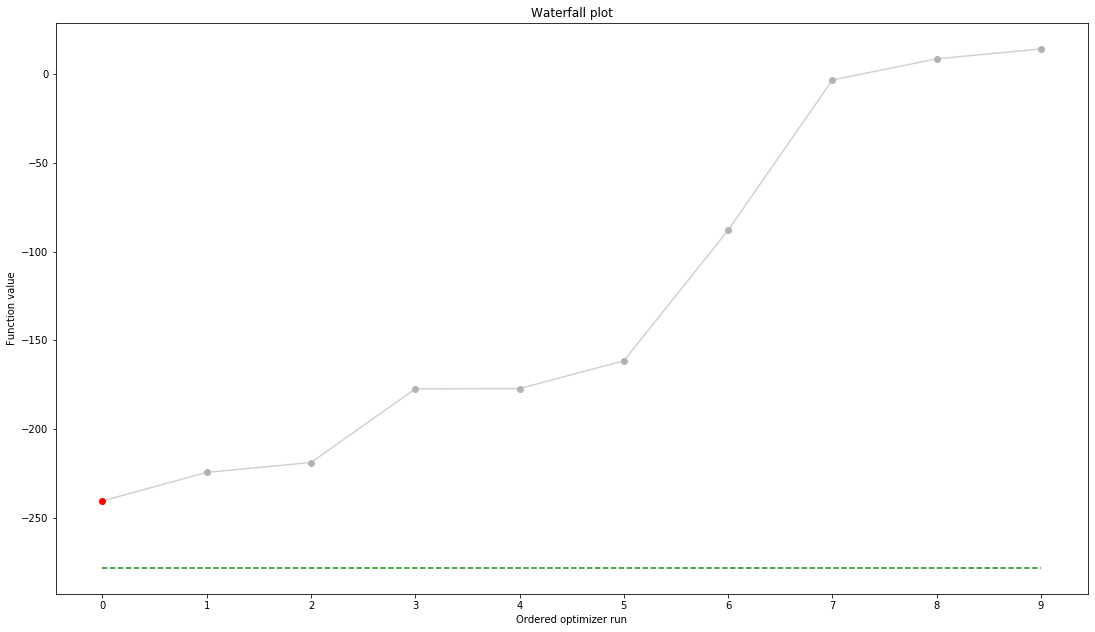

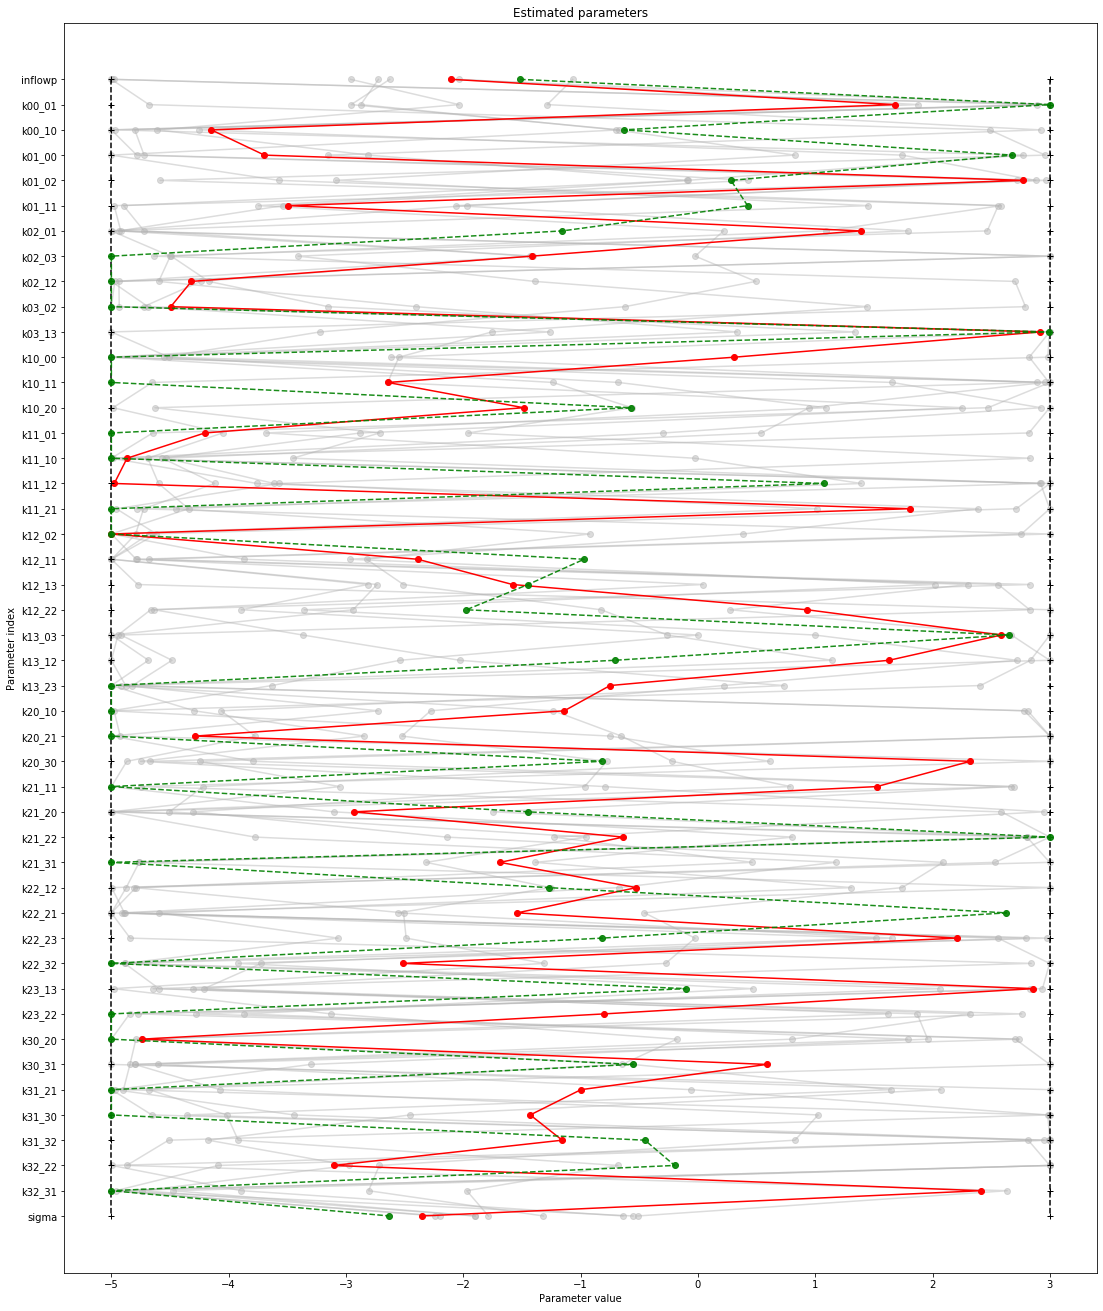

In [11]:
import pypesto.visualize

ref = pypesto.visualize.create_references(x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

pypesto.visualize.waterfall(result, reference=ref, scale_y='lin')
pypesto.visualize.parameters(result, reference=ref)